# Loading Essential Libraries

In [1]:
import pandas as pd
import numpy as np

# Dickey Fuller Test and ARIMA model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import pmdarima as pm



# Plotting
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline


# Exploring Data

In [2]:
df = pd.read_csv('/Users/dhruvpatel/Desktop/MUNCHKIN/DS Test Dataset.csv',parse_dates=['WEEK_START'], index_col='WEEK_START')



In [3]:
# Checking the data types to each field
df.dtypes

ITEM_NUMBER     object
orders         float64
POS            float64
ON_HAND        float64
Price          float64
WOS            float64
STORE_COUNT    float64
CATEGORY        object
SUBCATEGORY     object
dtype: object

# Looking at the POS distribution of ITEM_2

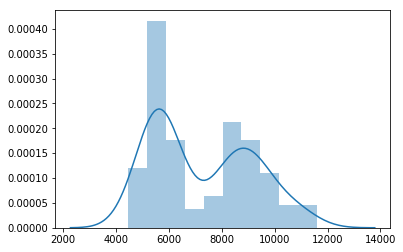

In [4]:
# Looking at the POS distribution of ITEM_2 to see if check stationarity

X = df.loc[df['ITEM_NUMBER'] == 'ITEM_2',['POS']].values
X = X[~np.isnan(X)]  #Removing the NAN value since there is only one in the dataframe


sns.distplot(X, bins = 10)


## Conclusion - data seems follow distribution other than normal



# Is our data Stationary?

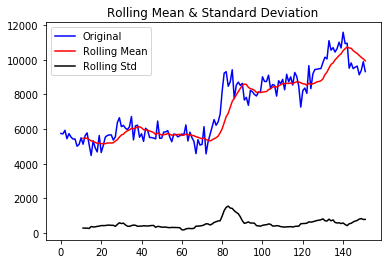

Results of Dickey-Fuller Test:
Test Statistic                  -0.861934
p-value                          0.800249
#Lags Used                       2.000000
Number of Observations Used    149.000000
Critical Value (1%)             -3.475018
Critical Value (5%)             -2.881141
Critical Value (10%)            -2.577221
dtype: float64


In [5]:
# Testing Stationarity
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.DataFrame.rolling(timeseries, window=12).mean()
    rolstd = pd.DataFrame.rolling(timeseries, window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(pd.Series(X))


## Confirmed that data has some sort of trend and sesonality associated with it. 


# Transformation of data (Log Transformation)


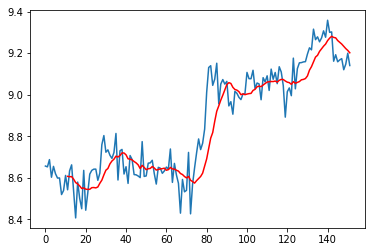

In [6]:
# Transformation to remove the Seasonality and Trend from Time Series
# Lets take log transformation

X_log = np.log(X)

# Plotting Moving Average
moving_avg = pd.DataFrame.rolling(pd.Series(X_log), window=12).mean()
plt.plot(X_log)
plt.plot(moving_avg, color='red')



## After Transformation, checking if our data becomes stationary or not

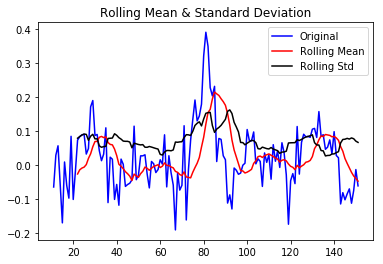

Results of Dickey-Fuller Test:
Test Statistic                  -4.974501
p-value                          0.000025
#Lags Used                       7.000000
Number of Observations Used    133.000000
Critical Value (1%)             -3.480500
Critical Value (5%)             -2.883528
Critical Value (10%)            -2.578496
dtype: float64


In [7]:
X_log_moving_avg_diff = X_log - moving_avg

X_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(X_log_moving_avg_diff)




## It seems like the data is stationary since test statistic is less than Critical value (1%)



# Eliminating the Trend and Seasonality
## Differencing lag by 1 shift

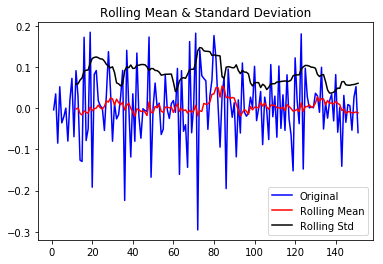

Results of Dickey-Fuller Test:
Test Statistic                  -4.158377
p-value                          0.000774
#Lags Used                       7.000000
Number of Observations Used    143.000000
Critical Value (1%)             -3.476927
Critical Value (5%)             -2.881973
Critical Value (10%)            -2.577665
dtype: float64


In [8]:
# Eliminating Trend and Seasonality
# Differencing
X_log_diff = X_log - pd.Series(X_log).shift(1)

X_log_diff.dropna(inplace=True)
test_stationarity(X_log_diff)


### Since we are shifting by 1 lag, we will keep the value of d = 1


# Decomposition

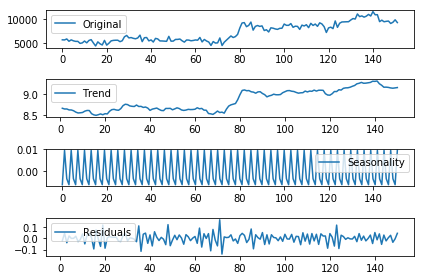

In [9]:
X_log = pd.Series(X_log)
decomposition = seasonal_decompose(X_log, freq=3)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(pd.Series(X), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Checking Stationarity of residual

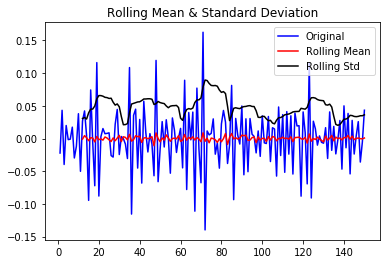

Results of Dickey-Fuller Test:
Test Statistic                -1.072114e+01
p-value                        3.148645e-19
#Lags Used                     5.000000e+00
Number of Observations Used    1.440000e+02
Critical Value (1%)           -3.476598e+00
Critical Value (5%)           -2.881829e+00
Critical Value (10%)          -2.577589e+00
dtype: float64


In [10]:
X_log_decompose = residual
X_log_decompose.dropna(inplace=True)
test_stationarity(X_log_decompose)

## The Test statistic is < 1% of Critical value. This means the residuals are stationary


# Plotting ACF and PCF 

Text(0.5,1,'Autocorrelation Function')

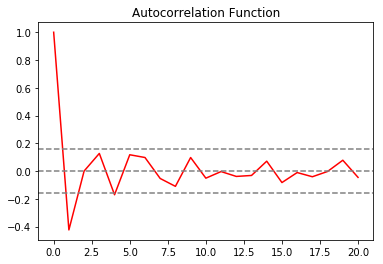

In [11]:

lag_acf = acf(X_log_diff, nlags=20)
lag_pacf = pacf(X_log_diff, nlags=20, method='ols')

#Plot ACF:  

plt.plot(lag_acf, color = 'red')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(X_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(X_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')




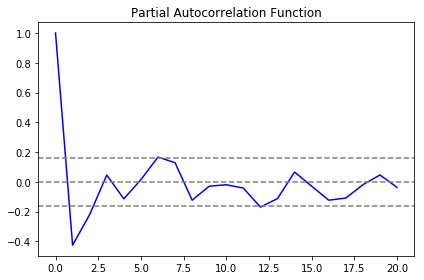

In [12]:
#Plot PACF:
plt.plot(lag_pacf, color = 'blue')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(X_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(X_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### The value of p=1 and q=1 or 0 because first time the line enters into the confidence interval is at 1 and kind of between 0 and 1. So, lets try both

# AR MODEL 

Text(0.5,1,'RSS: 0.8772')

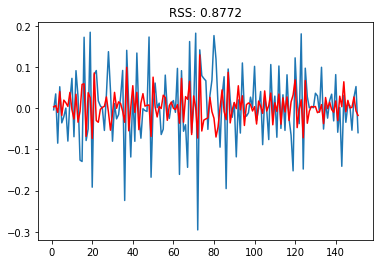

In [13]:
model = ARIMA(X_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(X_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-X_log_diff)**2))

# MA MODEL

Text(0.5,1,'RSS: 0.8483')

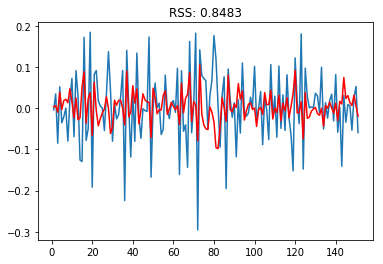

In [14]:
model = ARIMA(X_log, order=(0, 1,1))  
results_MA = model.fit(disp=-1)  
plt.plot(X_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-X_log_diff)**2))

# ARIMA MODEL

Text(0.5,1,'RSS: 0.8435')

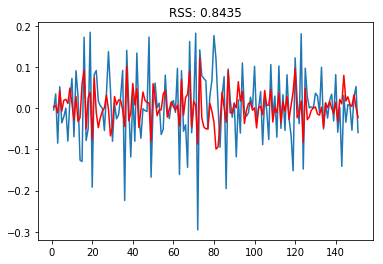

In [15]:
model = ARIMA(X_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(X_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-X_log_diff)**2))


## We gonna check out AR MODEL eventhough the RSS value of the model is lower. The ARIMA model doesn't fit well with our data

In [16]:
# Transforming back to the original values

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
# print(predictions_ARIMA_diff)

# Taking the cumulative sum to remove the lag
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# print(predictions_ARIMA_diff_cumsum)


predictions_ARIMA_log = pd.Series(X_log.ix[0], index=X_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1,'RMSE: 1902.8665')

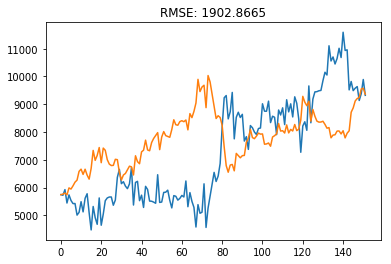

In [17]:
# Plotting how will ARIMA model looks like
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(X)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-X)**2)/len(X)))



## Conclusion: MA Model with log transformation does fit well considering the assumptions are matching.

## Cross Validation on MA MODEL to see if the log transformation is best or not
#### Taking first 120 weeks as a train and 31 as test, then checking if they are correct or not


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  119
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 132.571
Method:                       css-mle   S.D. of innovations              0.079
Date:                Sun, 04 Aug 2019   AIC                           -259.142
Time:                        21:59:14   BIC                           -250.805
Sample:                             1   HQIC                          -255.757
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.004      0.713      0.477      -0.005       0.010
ma.L1.D.y     -0.4728      0.075     -6.281      0.000      -0.620      -0.325
                                    Roots           

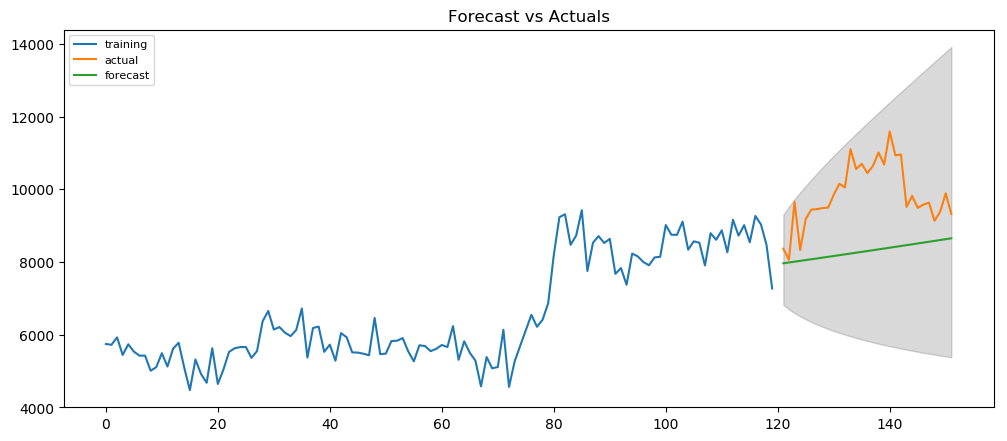

{'mape': 0.018338775614640857,
 'me': -0.16930200423362787,
 'mae': 0.16930200423362787,
 'mpe': -0.018338775614640857,
 'rmse': 0.1875482882760198,
 'acf1': 0.6303403869994672,
 'corr': 0.3271561883430082,
 'minmax': 0.018338775614640923}

In [18]:
# CROSS VALIDATION
# Create Training and Test
train = pd.Series(X_log[:120])
test = pd.Series(X_log[121:])


# Build Model
model = ARIMA(train, order=(0, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(31, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(np.exp(train), label='training')
plt.plot(np.exp(test), label='actual')
plt.plot(np.exp(fc_series), label='forecast')
plt.fill_between(lower_series.index, np.exp(lower_series), np.exp(upper_series), 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

# # Reference Key
# Mean Absolute Percentage Error (MAPE)
# Mean Error (ME)
# Mean Absolute Error (MAE)
# Mean Percentage Error (MPE)
# Root Mean Squared Error (RMSE)
# Lag 1 Autocorrelation of Error (ACF1)
# Correlation between the Actual and the Forecast (corr)
# Min-Max Error (minmax)

### mape is 1.8% that means the model is 98.2% accurate in predicting next 31 days


## AUTO ARIMA 


In [19]:
# Using the pmdarima to get the best model with the lowest AIC and BIC
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(X, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

# Even the auto-arima function gives us the best function to be ARIMA(0,1,1)

Fit ARIMA: order=(1, 1, 1); AIC=2325.121, BIC=2337.190, Fit time=0.099 seconds
Fit ARIMA: order=(0, 1, 0); AIC=2351.676, BIC=2357.710, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=2325.746, BIC=2334.798, Fit time=0.030 seconds
Fit ARIMA: order=(0, 1, 1); AIC=2324.187, BIC=2333.239, Fit time=0.029 seconds
Fit ARIMA: order=(0, 1, 2); AIC=2325.025, BIC=2337.094, Fit time=0.023 seconds
Fit ARIMA: order=(1, 1, 2); AIC=2326.890, BIC=2341.976, Fit time=0.124 seconds
Total fit time: 0.323 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  151
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1159.094
Method:                       css-mle   S.D. of innovations            521.395
Date:                Sun, 04 Aug 2019   AIC                           2324.187
Time:                        21:59:15   BIC                           2333.239
Sample:               

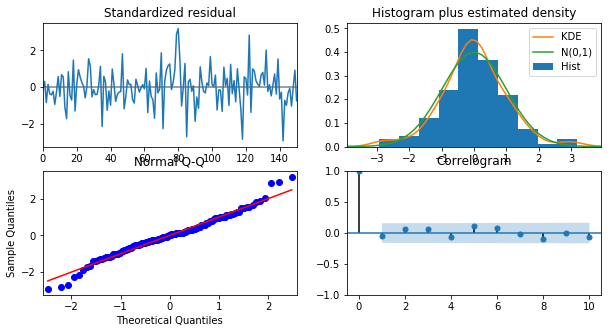

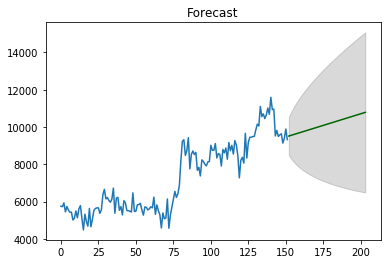

In [20]:
model.plot_diagnostics(figsize=(10,5))
plt.show()


# Forecast
n_periods = 52
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(X), len(X)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(X)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Forecast")
plt.show()

# AUTO ARIMA SEASONAL

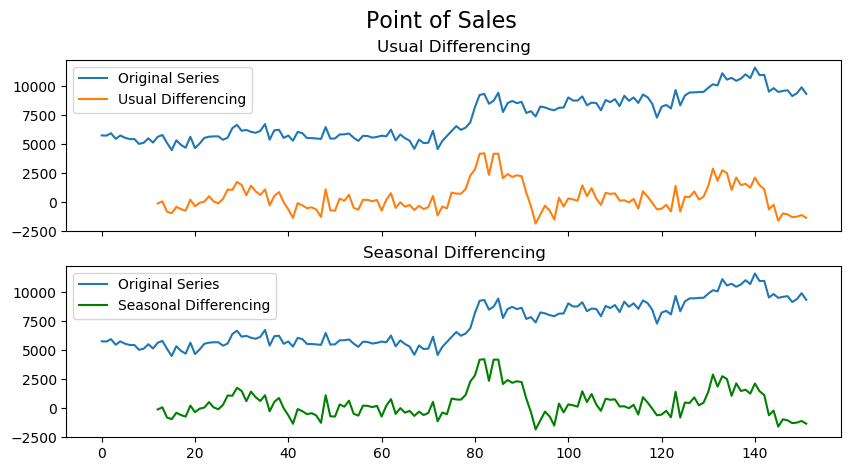

In [21]:
# Improving the model by using Seasonal ARIMA Model 
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(X, label='Original Series')
axes[0].plot((pd.Series(X)).diff(12), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(X, label='Original Series')
axes[1].plot((pd.Series(X)).diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Point of Sales', fontsize=16)
plt.show()


In [22]:
smodel = pm.auto_arima(X_log, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-280.160, BIC=-265.488, Fit time=0.914 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-181.545, BIC=-175.676, Fit time=0.027 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-249.898, BIC=-238.160, Fit time=0.402 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-281.339, BIC=-269.601, Fit time=0.705 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-281.036, BIC=-266.364, Fit time=1.123 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-205.703, BIC=-196.899, Fit time=0.098 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-281.181, BIC=-266.509, Fit time=1.983 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-279.248, BIC=-261.641, Fit time=2.820 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-252.913, BIC=-244.109, Fit time=0.303 seconds
Fit ARIMA: order=(0, 1, 2) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  152
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 144.670
Date:                            Sun, 04 Aug 2019   AIC                           -281.339
Time:                                    21:59:26   BIC                           -269.601
Sample:                                         0   HQIC                          -276.569
                                            - 152                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.001      0.252      0.801      -0.002       0.003
ma.L1         -0.4569      0.060     -7.642      0.000      -0.574      -0.340
ma.S.L12      -0.8744      0.118     -7.400      0.000      -1.106      -0.643
sigma2         0.0065      0.001      8.868      0.000       0.005       0.008
===================================================================================
Ljung-Box (Q):                       35.82   Jarque-Bera (JB):                 2.72
Prob(Q):                              0.66   Prob(JB):                         0.26
Heteroskedasticity (H):               0.75   Skew:                            -0.01
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Forecast for next 52 weeks using Auto ARIMA Seasonal Forecast Model

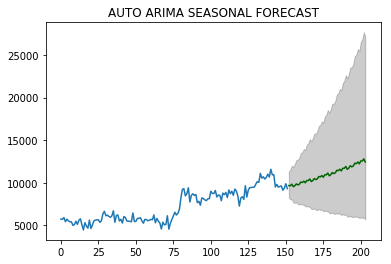

In [23]:

n_periods = 52
fc, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(X_log), len(X_log)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(np.exp(fc), index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(X)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 np.exp(lower_series), 
                 np.exp(upper_series), 
                 color='k', alpha=.2)

plt.title("AUTO ARIMA SEASONAL FORECAST")
plt.show()

# Getting the seasonal information from here

# FINAL MODEL for ITEM_2 =  SARIMA(0,1,1) (0,1,1,12)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


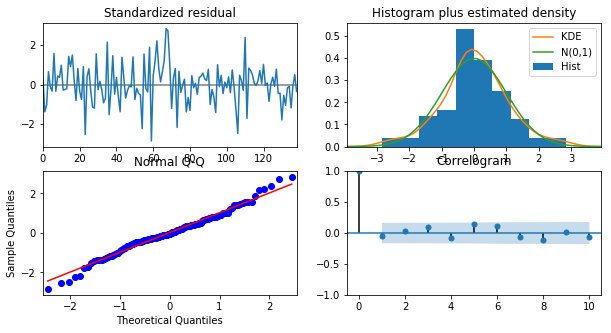

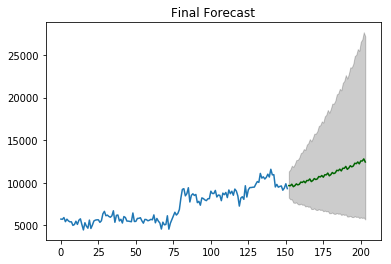

In [24]:
import pmdarima as pm

arima = pm.ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
test_1 = arima.fit(X_log)

test_1.plot_diagnostics(figsize=(10,5))
plt.show()

# Forecast
n_periods = 52
fc, confint = test_1.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(X_log), len(X_log)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(np.exp(fc), index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(X)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 np.exp(lower_series), 
                 np.exp(upper_series), 
                 color='k', alpha=.2)

plt.title("Final Forecast")
plt.show()


## MODEL SELECTED FOR ITEM_2 is SARIMA(0,1,1) (0,1,1,12) also includes log transformation to make the data stationary